<a href="https://colab.research.google.com/github/hv4626/SuperGlue-Implementation/blob/main/ee769_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# SuperGlue Implementation and Training on Retinal Images

### - Asif Shaikh 20d070017
### - Harshvardhan 20d070035
### - Keshav Singhal 20d070047

## Dataset Used -  Retinal Image Pairs, MeDAL
### Acknowledgements:
### Sahar Almahfouz Nasser (PhD Student, IIT Bombay)
### Nihar Gupte (Postgraduate Student, IIT Bombay)
### Keshav Singhal (Undergraduate Student, IIT Bombay)
### Prateek Garg (Undergraduate Student, IIT Bombay)
### Tanmay Jain (Undergraduate Student, IIT Bombay)

In [ ]:
import numpy as np

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
#Drive mounted to extract dataset
#Download dataset from https://drive.google.com/drive/folders/1oE0Q38fgnOM4c8Hx8AUm3vn2TeTkX_tN?usp=sharing into your Gdrive

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Code from https://github.com/magicleap/SuperGluePretrainedNetwork 
### SUPERGLUE: LEARNING FEATURE MATCHING WITH GRAPH NEURAL NETWORKS
### ACADEMIC OR NON-PROFIT ORGANIZATION NONCOMMERCIAL RESEARCH USE ONLY
### Liscense: https://github.com/magicleap/SuperGluePretrainedNetwork/blob/master/LICENSE

In [ ]:
# Acknowledgement for this code block
#  Magic Leap, Inc. ("COMPANY") CONFIDENTIAL
#
#  Unpublished Copyright (c) 2020
#  Magic Leap, Inc., All Rights Reserved.


from pathlib import Path
import time
from collections import OrderedDict
from threading import Thread
import numpy as np
import cv2
import torch
import matplotlib.pyplot as plt
import matplotlib
matplotlib.use('Agg')


# --- PREPROCESSING ---

# Function to resize an image with given width, height, and resize parameter
def process_resize(w, h, resize):
    assert(len(resize) > 0 and len(resize) <= 2)  # Check if resize parameter has valid length 
    if len(resize) == 1 and resize[0] > -1:       # If there is only one value in resize list and it is positive 
        scale = resize[0] / max(h, w)             # Calculate the scaling factor based on the larger dimension and resize the image
        w_new, h_new = int(round(w*scale)), int(round(h*scale))
    elif len(resize) == 1 and resize[0] == -1:    # If there is only one value in resize list and it is negative
        w_new, h_new = w, h                       # Keep the original dimensions of the image
    else:                                         
        w_new, h_new = resize[0], resize[1]       # Use the given dimensions to resize the image

    # Issue a warning if the new resolution is too small or too large.
    if max(w_new, h_new) < 160:
        print('Warning: input resolution is very small, results may vary')
    elif max(w_new, h_new) > 2000:
        print('Warning: input resolution is very large, results may vary')

    # Return the new dimensions of the image
    return w_new, h_new

# Convert a numpy array representing an image frame to a PyTorch tensor.
def frame2tensor(frame):
  # Normalize pixel values between 0 and 1.
  normalized_frame = frame / 255.
  # Convert the numpy array to a PyTorch tensor, adding two dimensions to the tensor.
  # The first dimension is the batch dimension (None is the same as 0), and the second dimension is the channel dimension.
  tensor = torch.from_numpy(normalized_frame).float()[None, None]
  # Move the tensor to the GPU.
  tensor = tensor.cuda()
  return tensor

# This function reads an image file from a given path, resizes it, rotates it if specified, and converts it to a float32 numpy array.

def read_image(path, resize, rotation, resize_float):
    # read the image file as a grayscale image using OpenCV
    image = cv2.imread(str(path), cv2.IMREAD_GRAYSCALE)
    # If there's no image file at the path, return None for all values.
    if image is None:
        return None, None, None
    # Get the current image width and height.
    w, h = image.shape[1], image.shape[0]
    # Process the resizing of the image based on the arguments.
    w_new, h_new = process_resize(w, h, resize)
    # Calculate the scale of the image.
    scales = (float(w) / float(w_new), float(h) / float(h_new))

    # Resize the image with a float data type if resize_float is True.
    if resize_float:
        image = cv2.resize(image.astype('float32'), (w_new, h_new))
    # Resize the image with an integer data type if resize_float is False.
    else:
        image = cv2.resize(image, (w_new, h_new)).astype('float32')
    # Return the image, scale, and rotation.
    return image, scales, rotation


# --- VISUALIZATION ---

def plot_image_pair(imgs, dpi=100, size=6, pad=.5):
    # Get the number of images
    n = len(imgs)
    # Make sure there are two images to plot
    assert n == 2, 'number of images must be two'
    # Determine the size of the figure based on the input parameters
    figsize = (size*n, size*3/4) if size is not None else None
    # Create a new figure with one row and n columns
    _, ax = plt.subplots(1, n, figsize=figsize, dpi=dpi)
    # Loop over each image
    for i in range(n):
        # Show the current image with a gray colormap
        ax[i].imshow(imgs[i], cmap=plt.get_cmap('gray'), vmin=0, vmax=255)
        # Remove y-axis ticks
        ax[i].get_yaxis().set_ticks([])
        # Remove x-axis ticks
        ax[i].get_xaxis().set_ticks([])
        # Remove the frame of the plot
        for spine in ax[i].spines.values():
            spine.set_visible(False)
    # Adjust the layout of the figure to avoid overlapping subplots
    plt.tight_layout(pad=pad)

# plot_keypoints function: plot keypoints from two sets of coordinates
def plot_keypoints(kpts0, kpts1, color='w', ps=2):
    # Get the current figure's axes
    ax = plt.gcf().axes
    # Scatter plot of the first set of keypoints in the first subplot
    ax[0].scatter(kpts0[:, 0], kpts0[:, 1], c=color, s=ps)
    # Scatter plot of the second set of keypoints in the second subplot
    ax[1].scatter(kpts1[:, 0], kpts1[:, 1], c=color, s=ps)


def plot_matches(kpts0, kpts1, color, lw=1.5, ps=4):
    # Get the current figure and its axes.
    fig = plt.gcf()
    ax = fig.axes

    # Draw the canvas to update the renderer.
    fig.canvas.draw()

    # Get the transformation matrix to convert data coordinates to figure coordinates.
    transFigure = fig.transFigure.inverted()

    # Transform the keypoints from data coordinates to figure coordinates.
    fkpts0 = transFigure.transform(ax[0].transData.transform(kpts0))
    fkpts1 = transFigure.transform(ax[1].transData.transform(kpts1))

    # Create lines to connect the keypoints in the two images.
    fig.lines = [matplotlib.lines.Line2D(
        (fkpts0[i, 0], fkpts1[i, 0]), (fkpts0[i, 1], fkpts1[i, 1]), zorder=1,
        transform=fig.transFigure, c=color[i], linewidth=lw)
                 for i in range(len(kpts0))]

    # Scatter plot the keypoints in each image.
    ax[0].scatter(kpts0[:, 0], kpts0[:, 1], c=color, s=ps)
    ax[1].scatter(kpts1[:, 0], kpts1[:, 1], c=color, s=ps)


def make_matching_plot(image0, image1, kpts0, kpts1, mkpts0, mkpts1,
                       color, text, path, name0, name1, show_keypoints=False,
                       fast_viz=False, opencv_display=False, opencv_title='matches'):

    # if fast visualization mode is selected
    if fast_viz:
        make_matching_plot_fast(image0, image1, kpts0, kpts1, mkpts0, mkpts1,
                                color, text, path, show_keypoints, 10,
                                opencv_display, opencv_title)
        return

    # plot the image pair
    plot_image_pair([image0, image1])

    # if show_keypoints is enabled, plot the keypoints
    if show_keypoints:
        plot_keypoints(kpts0, kpts1, color='k', ps=4)
        plot_keypoints(kpts0, kpts1, color='w', ps=2)

    # plot the matches
    plot_matches(mkpts0, mkpts1, color)

    fig = plt.gcf()

    # set the color of the text based on the brightness of the images
    txt_color = 'k' if image0[:100, :150].mean() > 200 else 'w'

    # add the text for the figure
    fig.text(
        0.01, 0.99, '\n'.join(text), transform=fig.axes[0].transAxes,
        fontsize=15, va='top', ha='left', color=txt_color)

    # add the name of the first image
    txt_color = 'k' if image0[-100:, :150].mean() > 200 else 'w'
    fig.text(
        0.01, 0.01, name0, transform=fig.axes[0].transAxes,
        fontsize=5, va='bottom', ha='left', color=txt_color)

    # add the name of the second image
    txt_color = 'k' if image1[-100:, :150].mean() > 200 else 'w'
    fig.text(
        0.01, 0.01, name1, transform=fig.axes[1].transAxes,
        fontsize=5, va='bottom', ha='left', color=txt_color)

    # save the figure and close it
    plt.savefig(str(path), bbox_inches='tight', pad_inches=0)
    plt.close()


def make_matching_plot_fast(image0, image1, kpts0, kpts1, mkpts0, mkpts1, color, text, path=None, show_keypoints=False, margin=10, opencv_display=False, opencv_title='Match'):
    # Get height and width of the input images
    H0, W0 = image0.shape
    H1, W1 = image1.shape
    
    # Calculate the output image's height and width
    H, W = max(H0, H1), W0 + W1 + margin
    
    # Create an all white image of the calculated size
    out = 255*np.ones((H, W), np.uint8)
    
    # Copy the first image to the top left corner of the output image
    out[:H0, :W0] = image0
    
    # Copy the second image to the right of the first image with a margin
    out[:H1, W0+margin:] = image1
    
    # Convert the image to a 3 channel color image
    out = np.stack([out]*3, -1)

    # If requested, draw the keypoints of the input images
    if show_keypoints:
        kpts0, kpts1 = np.round(kpts0).astype(int), np.round(kpts1).astype(int)
        white = (255, 255, 255)
        black = (0, 0, 0)
        for x, y in kpts0:
            cv2.circle(out, (x, y), 2, black, -1, lineType=cv2.LINE_AA)
            cv2.circle(out, (x, y), 1, white, -1, lineType=cv2.LINE_AA)
        for x, y in kpts1:
            cv2.circle(out, (x + margin + W0, y), 2, black, -1, lineType=cv2.LINE_AA)
            cv2.circle(out, (x + margin + W0, y), 1, white, -1, lineType=cv2.LINE_AA)

    # Round the matched keypoints and convert the color to RGB format
    mkpts0, mkpts1 = np.round(mkpts0).astype(int), np.round(mkpts1).astype(int)
    color = (np.array(color[:, :3])*255).astype(int)[:, ::-1]
    
    # Draw the lines and circles between the matched keypoints
    for (x0, y0), (x1, y1), c in zip(mkpts0, mkpts1, color):
        c = c.tolist()
        cv2.line(out, (x0, y0), (x1 + margin + W0, y1), color=c, thickness=1, lineType=cv2.LINE_AA)
        cv2.circle(out, (x0, y0), 2, c, -1, lineType=cv2.LINE_AA)
        cv2.circle(out, (x1 + margin + W0, y1), 2, c, -1, lineType=cv2.LINE_AA)

    # Calculate the text height
    Ht = int(H * 30 / 480)
    
    # Set the text color and font
    txt_color_fg = (255, 255, 255)
    txt_color_bg = (0, 0, 0)
    
    # Draw the text on the output image
    for i, t in enumerate(text):
        cv2.putText(out, t, (10, Ht*(i+1)), cv2.FONT_HERSHEY_DUPLEX,
                    H*1.0/480, txt_color_bg, 2, cv2.LINE_AA)
        cv2.putText(out, t, (10, Ht*(i+1)), cv2.FONT_HERSHEY_DUPLEX,
                    H*1.0/480, txt_color_fg, 1, cv2.LINE_AA)

    if path is not None:
        cv2.imwrite(str(path), out)

    if opencv_display:
        cv2.imshow(opencv_title, out)
        cv2.waitKey(1)

    return out


def error_colormap(x):
    # Scale the input error values to the range [0, 2]
    scaled_x = 2 - x * 2

    # Stack the color channels for the output color map.
    # We use the scaled_x as red and the complement of scaled_x as green
    # Blue channel is all zeros and alpha channel is all ones
    cmap = np.stack([scaled_x, x * 2, np.zeros_like(x), np.ones_like(x)], -1)

    # Clip the color map to the range [0, 1] to ensure valid colors
    cmap = np.clip(cmap, 0, 1)

    return cmap

In [ ]:
# Acknowledgement for this code block
#  Magic Leap, Inc. ("COMPANY") CONFIDENTIAL
#
#  Unpublished Copyright (c) 2020
#  Magic Leap, Inc., All Rights Reserved.

from copy import deepcopy
from pathlib import Path
import torch
from torch import nn


def MLP(channels: list, do_bn=True):
    """ Multi-layer perceptron """
    n = len(channels)
    layers = []
    for i in range(1, n):
        layers.append(
            nn.Conv1d(channels[i - 1], channels[i], kernel_size=1, bias=True))
        if i < (n-1):
            if do_bn:
                # layers.append(nn.BatchNorm1d(channels[i]))
                layers.append(nn.InstanceNorm1d(channels[i]))
            layers.append(nn.ReLU())
    return nn.Sequential(*layers)


def normalize_keypoints(kpts, image_shape):
    """ Normalize keypoints locations based on image image_shape"""
    _, _, height, width = image_shape
    one = kpts.new_tensor(1)
    size = torch.stack([one*width, one*height])[None]
    center = size / 2
    scaling = size.max(1, keepdim=True).values * 0.7
    return (kpts - center[:, None, :]) / scaling[:, None, :]


class KeypointEncoder(nn.Module):
    """ Joint encoding of visual appearance and location using MLPs"""
    def __init__(self, feature_dim, layers):
        super().__init__()
        self.encoder = MLP([3] + layers + [feature_dim])
        nn.init.constant_(self.encoder[-1].bias, 0.0)

    def forward(self, kpts, scores):
        inputs = [kpts.transpose(1, 2), scores.unsqueeze(1)]
        return self.encoder(torch.cat(inputs, dim=1))


def attention(query, key, value):
    dim = query.shape[1]
    scores = torch.einsum('bdhn,bdhm->bhnm', query, key) / dim**.5
    prob = torch.nn.functional.softmax(scores, dim=-1)
    return torch.einsum('bhnm,bdhm->bdhn', prob, value), prob


class MultiHeadedAttention(nn.Module):
    """ Multi-head attention to increase model expressivitiy """
    def __init__(self, num_heads: int, d_model: int):
        super().__init__()
        assert d_model % num_heads == 0
        self.dim = d_model // num_heads
        self.num_heads = num_heads
        self.merge = nn.Conv1d(d_model, d_model, kernel_size=1)
        self.proj = nn.ModuleList([deepcopy(self.merge) for _ in range(3)])

    def forward(self, query, key, value):
        batch_dim = query.size(0)
        query, key, value = [l(x).view(batch_dim, self.dim, self.num_heads, -1)
                             for l, x in zip(self.proj, (query, key, value))]
        x, prob = attention(query, key, value)
        self.prob.append(prob)
        return self.merge(x.contiguous().view(batch_dim, self.dim*self.num_heads, -1))


class AttentionalPropagation(nn.Module):
    def __init__(self, feature_dim: int, num_heads: int):
        super().__init__()
        self.attn = MultiHeadedAttention(num_heads, feature_dim)
        self.mlp = MLP([feature_dim*2, feature_dim*2, feature_dim])
        nn.init.constant_(self.mlp[-1].bias, 0.0)

    def forward(self, x, source):
        message = self.attn(x, source, source)
        return self.mlp(torch.cat([x, message], dim=1))


class AttentionalGNN(nn.Module):
    def __init__(self, feature_dim: int, layer_names: list):
        super().__init__()
        self.layers = nn.ModuleList([
            AttentionalPropagation(feature_dim, 4)
            for _ in range(len(layer_names))])
        self.names = layer_names

    def forward(self, desc0, desc1):
        for layer, name in zip(self.layers, self.names):
            layer.attn.prob = []
            if name == 'cross':
                src0, src1 = desc1, desc0
            else:  # if name == 'self':
                src0, src1 = desc0, desc1
            delta0, delta1 = layer(desc0, src0), layer(desc1, src1)
            desc0, desc1 = (desc0 + delta0), (desc1 + delta1)
        return desc0, desc1


def log_sinkhorn_iterations(Z, log_mu, log_nu, iters: int):
    """ Perform Sinkhorn Normalization in Log-space for stability"""
    u, v = torch.zeros_like(log_mu), torch.zeros_like(log_nu)
    for _ in range(iters):
        u = log_mu - torch.logsumexp(Z + v.unsqueeze(1), dim=2)
        v = log_nu - torch.logsumexp(Z + u.unsqueeze(2), dim=1)
    return Z + u.unsqueeze(2) + v.unsqueeze(1)


def log_optimal_transport(scores, alpha, iters: int):
    """ Perform Differentiable Optimal Transport in Log-space for stability"""
    b, m, n = scores.shape
    one = scores.new_tensor(1)
    ms, ns = (m*one).to(scores), (n*one).to(scores)

    bins0 = alpha.expand(b, m, 1)
    bins1 = alpha.expand(b, 1, n)
    alpha = alpha.expand(b, 1, 1)

    couplings = torch.cat([torch.cat([scores, bins0], -1),
                           torch.cat([bins1, alpha], -1)], 1)

    norm = - (ms + ns).log()
    log_mu = torch.cat([norm.expand(m), ns.log()[None] + norm])
    log_nu = torch.cat([norm.expand(n), ms.log()[None] + norm])
    log_mu, log_nu = log_mu[None].expand(b, -1), log_nu[None].expand(b, -1)

    Z = log_sinkhorn_iterations(couplings, log_mu, log_nu, iters)
    Z = Z - norm  # multiply probabilities by M+N
    return Z


def arange_like(x, dim: int):
    return x.new_ones(x.shape[dim]).cumsum(0) - 1  # traceable in 1.1


class SuperGlue(nn.Module):
    """SuperGlue feature matching middle-end

    Given two sets of keypoints and locations, we determine the
    correspondences by:
      1. Keypoint Encoding (normalization + visual feature and location fusion)
      2. Graph Neural Network with multiple self and cross-attention layers
      3. Final projection layer
      4. Optimal Transport Layer (a differentiable Hungarian matching algorithm)
      5. Thresholding matrix based on mutual exclusivity and a match_threshold

    The correspondence ids use -1 to indicate non-matching points.

    Paul-Edouard Sarlin, Daniel DeTone, Tomasz Malisiewicz, and Andrew
    Rabinovich. SuperGlue: Learning Feature Matching with Graph Neural
    Networks. In CVPR, 2020. https://arxiv.org/abs/1911.11763

    """
    default_config = {
        'descriptor_dim': 128,
        'weights': 'indoor',
        'keypoint_encoder': [32, 64, 128],
        'GNN_layers': ['self', 'cross'] * 9,
        'sinkhorn_iterations': 100,
        'match_threshold': 0.2,
    }

    def __init__(self, config):
        super().__init__()
        self.config = {**self.default_config, **config}

        self.kenc = KeypointEncoder(
            self.config['descriptor_dim'], self.config['keypoint_encoder'])

        self.gnn = AttentionalGNN(
            self.config['descriptor_dim'], self.config['GNN_layers'])

        self.final_proj = nn.Conv1d(
            self.config['descriptor_dim'], self.config['descriptor_dim'],
            kernel_size=1, bias=True)

        bin_score = torch.nn.Parameter(torch.tensor(1.))
        self.register_parameter('bin_score', bin_score)

        # assert self.config['weights'] in ['indoor', 'outdoor']
        # path = Path(__file__).parent
        # path = path / 'weights/superglue_{}.pth'.format(self.config['weights'])
        # self.load_state_dict(torch.load(path))
        # print('Loaded SuperGlue model (\"{}\" weights)'.format(
        #     self.config['weights']))

    def forward(self, data):
        """Run SuperGlue on a pair of keypoints and descriptors"""
        desc0, desc1 = data['descriptors0'].double(), data['descriptors1'].double()
        kpts0, kpts1 = data['keypoints0'].double(), data['keypoints1'].double()

        desc0 = desc0.transpose(0,1)
        desc1 = desc1.transpose(0,1)
        kpts0 = torch.reshape(kpts0, (1, -1, 2))
        kpts1 = torch.reshape(kpts1, (1, -1, 2))
    
        if kpts0.shape[1] == 0 or kpts1.shape[1] == 0:  # no keypoints
            shape0, shape1 = kpts0.shape[:-1], kpts1.shape[:-1]
            return {
                'matches0': kpts0.new_full(shape0, -1, dtype=torch.int)[0],
                'matches1': kpts1.new_full(shape1, -1, dtype=torch.int)[0],
                'matching_scores0': kpts0.new_zeros(shape0)[0],
                'matching_scores1': kpts1.new_zeros(shape1)[0],
                'skip_train': True
            }

        file_name = data['file_name']
        all_matches = data['all_matches'].permute(1,2,0) # shape=torch.Size([1, 87, 2])
        
        # Keypoint normalization.
        kpts0 = normalize_keypoints(kpts0, data['image0'].shape)
        kpts1 = normalize_keypoints(kpts1, data['image1'].shape)

        # Keypoint MLP encoder.
        desc0 = desc0 + self.kenc(kpts0, torch.transpose(data['scores0'], 0, 1))
        desc1 = desc1 + self.kenc(kpts1, torch.transpose(data['scores1'], 0, 1))

        # Multi-layer Transformer network.
        desc0, desc1 = self.gnn(desc0, desc1)

        # Final MLP projection.
        mdesc0, mdesc1 = self.final_proj(desc0), self.final_proj(desc1)

        # Compute matching descriptor distance.
        scores = torch.einsum('bdn,bdm->bnm', mdesc0, mdesc1)
        scores = scores / self.config['descriptor_dim']**.5

        # Run the optimal transport.
        scores = log_optimal_transport(
            scores, self.bin_score,
            iters=self.config['sinkhorn_iterations'])

        # Get the matches with score above "match_threshold".
        max0, max1 = scores[:, :-1, :-1].max(2), scores[:, :-1, :-1].max(1)
        indices0, indices1 = max0.indices, max1.indices
        mutual0 = arange_like(indices0, 1)[None] == indices1.gather(1, indices0)
        mutual1 = arange_like(indices1, 1)[None] == indices0.gather(1, indices1)
        zero = scores.new_tensor(0)
        mscores0 = torch.where(mutual0, max0.values.exp(), zero)
        mscores1 = torch.where(mutual1, mscores0.gather(1, indices1), zero)
        valid0 = mutual0 & (mscores0 > self.config['match_threshold'])
        valid1 = mutual1 & valid0.gather(1, indices1)
        indices0 = torch.where(valid0, indices0, indices0.new_tensor(-1))
        indices1 = torch.where(valid1, indices1, indices1.new_tensor(-1))

        # check if indexed correctly
        loss = []
        for i in range(len(all_matches[0])):
            x = all_matches[0][i][0]
            y = all_matches[0][i][1]
            loss.append(-torch.log( scores[0][x][y].exp() )) # check batch size == 1 ?
        # for p0 in unmatched0:
        #     loss += -torch.log(scores[0][p0][-1])
        # for p1 in unmatched1:
        #     loss += -torch.log(scores[0][-1][p1])
        loss_mean = torch.mean(torch.stack(loss))
        loss_mean = torch.reshape(loss_mean, (1, -1))
        return {
            'matches0': indices0[0], # use -1 for invalid match
            'matches1': indices1[0], # use -1 for invalid match
            'matching_scores0': mscores0[0],
            'matching_scores1': mscores1[0],
            'loss': loss_mean[0],
            'skip_train': False
        }

        # scores big value or small value means confidence? log can't take neg value

# Data Loader (Original Work)

In [ ]:
import numpy as np
import torch
import os
import cv2
import math
import datetime

from scipy.spatial.distance import cdist
from torch.utils.data import Dataset

class SparseDataset(Dataset):
    """Sparse correspondences dataset."""

    def __init__(self, train_path, nfeatures):
        # Initialize instance variables
        self.folders = []  # List of folder paths
        self.path = train_path  # Path to the training data
        self.nfeatures = nfeatures  # Number of SIFT features to extract per image

        # Load the folders containing images
        indices = [int(x) for x in os.listdir(train_path)]
        indices.sort()
        self.folders += [os.path.join(train_path,str(x)) for x in indices]

        # Initialize SIFT feature extractor and matcher
        self.sift = cv2.xfeatures2d.SIFT_create(nfeatures=self.nfeatures)
        self.matcher = cv2.BFMatcher_create(cv2.NORM_L1, crossCheck=False)

        # Get folder indices and sort them
        self.folder_indices = [int(x) for x in os.listdir(train_path)]
        self.folder_indices.sort()

    def __len__(self):
        # Return the number of folders in the dataset
        return len(self.folders)

    def __getitem__(self, idx):
        # Get the folder name for the corresponding image pair index
        folder_name = self.folders[idx]
        
        # Get the image file names (excluding txt files) from the folder
        image1_name, image2_name = [x for x in os.listdir(folder_name) if os.path.splitext(x)[1]!='.txt']
        
        # Load the images as grayscale using OpenCV
        image1 = cv2.imread(os.path.join(folder_name,image1_name), cv2.IMREAD_GRAYSCALE) 
        image2 = cv2.imread(os.path.join(folder_name,image2_name), cv2.IMREAD_GRAYSCALE) 
        
        # Get the SIFT object and image dimensions
        sift = self.sift
        width, height = image1.shape[:2]

        # Get the keypoint file names for the images (default values are the image file names)
        kp1_file = image1_name + '.txt'
        kp2_file = image2_name + '.txt'
        
        # Look for the keypoint file names if they are different from the default values
        for f in os.listdir(folder_name):
            if f is not image1_name and f is not image2_name:
                if os.path.splitext(image1_name)[0] in f:
                    kp1_file = f
                elif os.path.splitext(image2_name)[0] in f:
                    kp2_file = f
        
        # Load the keypoints from the txt files
        kp1 = []
        with open(os.path.join(folder_name, kp1_file), 'r', encoding="utf8", errors='ignore') as f:
            contents = f.read().split('\n')
            for line in contents[:-1]:
                try:
                    x, y = line.strip().split(" ")
                    kp1.append((float(x), float(y)))
                except:
                    pass

        kp2 = []
        with open(os.path.join(folder_name, kp2_file), 'r', encoding="utf8", errors='ignore') as f:
            contents = f.read().split('\n')
            for line in contents[:-1]:
                try:
                    x, y = line.strip().split(" ")
                    kp2.append((float(x), float(y)))
                except:
                    pass

        # Convert the keypoints into cv2.KeyPoint objects
        kp1 = [cv2.KeyPoint(x, y, 1) for x, y in kp1]
        kp2 = [cv2.KeyPoint(x, y, 1) for x, y in kp2]

        # Compute the keypoints and descriptors for the two images using SIFT
        kp1, descs1 = sift.compute(image1, kp1)
        kp2, descs2 = sift.compute(image2, kp2)

        # Limit the number of keypoints for each image to self.nfeatures
        kp1_num = min(self.nfeatures, len(kp1))
        kp2_num = min(self.nfeatures, len(kp2))
        kp1 = kp1[:kp1_num]
        kp2 = kp2[:kp2_num]

        # Convert the keypoints into numpy arrays
        kp1_np = np.array([(kp.pt[0], kp.pt[1]) for kp in kp1])
        kp2_np = np.array([(kp.pt[0], kp.pt[1]) for kp in kp2])


        # skip this image pair if no keypoints detected in image
        if len(kp1) < 1 or len(kp2) < 1:
            return{
                'keypoints0': torch.zeros([0, 0, 2], dtype=torch.double),
                'keypoints1': torch.zeros([0, 0, 2], dtype=torch.double),
                'descriptors0': torch.zeros([0, 2], dtype=torch.double),
                'descriptors1': torch.zeros([0, 2], dtype=torch.double),
                'image0': image1,
                'image1': image2,
                'file_name': image1_name
            } 

        # confidence of each key point
        scores1_np = np.array([kp.response for kp in kp1]) 
        scores2_np = np.array([kp.response for kp in kp2])

        # Limit the number of descriptor points
        kp1_np = kp1_np[:kp1_num, :]
        kp2_np = kp2_np[:kp2_num, :]
        descs1 = descs1[:kp1_num, :]
        descs2 = descs2[:kp2_num, :]

        # COnvert all matched to a numpy array
        all_matches = np.array([list(range(len(kp1))), list(range(len(kp2)))])
        
        # Change dimensions as required and normalize everything
        kp1_np = kp1_np.reshape((1, -1, 2))
        kp2_np = kp2_np.reshape((1, -1, 2))
        descs1 = np.transpose(descs1 / 256.)
        descs2 = np.transpose(descs2 / 256.)

        image1 = torch.from_numpy(image1/255.).double()[None].cuda()
        image2 = torch.from_numpy(image2/255.).double()[None].cuda()

        # Return a dictionary containing everything
        return{
            'keypoints0': list(kp1_np),
            'keypoints1': list(kp2_np),
            'descriptors0': list(descs1),
            'descriptors1': list(descs2),
            'scores0': list(scores1_np),
            'scores1': list(scores2_np),
            'image0': image1,
            'image1': image2,
            'all_matches': list(all_matches),
            'file_name': image1_name
        } 


## Training Code (Original Work)

In [ ]:
import torch

class MatchingForTraining(torch.nn.Module):
    def __init__(self, config={}):
        super().__init__()
        self.superglue = SuperGlue(config.get('superglue', {}))  # create an instance of SuperGlue model with optional config settings

    def forward(self, data):
        pred = {} # initialize an empty dictionary
        data = {**data, **pred} # combine the pred dictionary with the data dictionary

        for k in data: # loop over the keys in the data dictionary
            if k == 'file_name': # if the key is 'file_name', continue to the next iteration
                continue
            if isinstance(data[k], (list, tuple)): # if the value associated with the key is a list or tuple
                data[k] = torch.stack(data[k]) # stack the list/tuple into a tensor
                data[k].requires_grad = True # set requires_grad to True
                
        # Perform the matching using the SuperGlue model
        pred = {**pred, **self.superglue(data)}
        pred = {**pred, **data} # combine the data dictionary with the updated pred dictionary

        for k in pred: # loop over the keys in the pred dictionary
            if k == 'file_name' or k == 'skip_train': # if the key is 'file_name' or 'skip_train', continue to the next iteration
                continue
            pred[k].requires_grad = True # set requires_grad to True for the tensor associated with the key
            
        return pred # return the updated pred dictionary


Epoch [1/5], Step [5/95], Loss: 0.8822
Epoch [1/5], Step [15/95], Loss: 0.5374
Epoch [1/5], Step [20/95], Loss: 0.5101
Epoch [1/5], Step [30/95], Loss: 0.1208
Epoch [1/5], Step [45/95], Loss: 0.1649
Epoch [1/5], Step [55/95], Loss: 0.0613
Epoch [1/5], Step [65/95], Loss: 0.4543
Epoch [1/5], Step [75/95], Loss: 0.2806
Epoch [1/5], Step [85/95], Loss: 0.6315
Epoch [1/5], Step [90/95], Loss: 0.4044
Epoch [1/5], Step [95/95], Loss: 0.3195
Epoch [1/5] done. Epoch Loss 0.17950977614709415. Checkpoint saved to model_epoch_1.pth


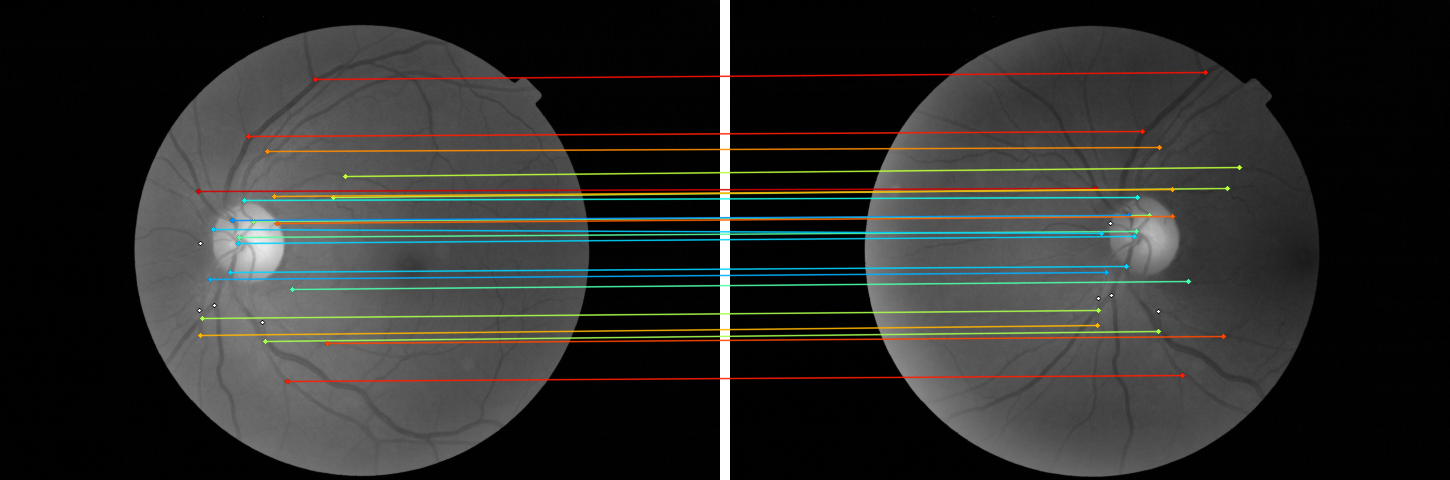

Epoch [2/5], Step [5/95], Loss: 0.0572
Epoch [2/5], Step [15/95], Loss: 0.1323
Epoch [2/5], Step [20/95], Loss: 0.1286
Epoch [2/5], Step [30/95], Loss: 0.0426
Epoch [2/5], Step [45/95], Loss: 0.0404
Epoch [2/5], Step [55/95], Loss: 0.0289
Epoch [2/5], Step [65/95], Loss: 0.1339
Epoch [2/5], Step [75/95], Loss: 0.1615
Epoch [2/5], Step [85/95], Loss: 0.2165
Epoch [2/5], Step [90/95], Loss: 0.1230
Epoch [2/5], Step [95/95], Loss: 0.1178
Epoch [2/5] done. Epoch Loss 0.04364948224390248. Checkpoint saved to model_epoch_2.pth


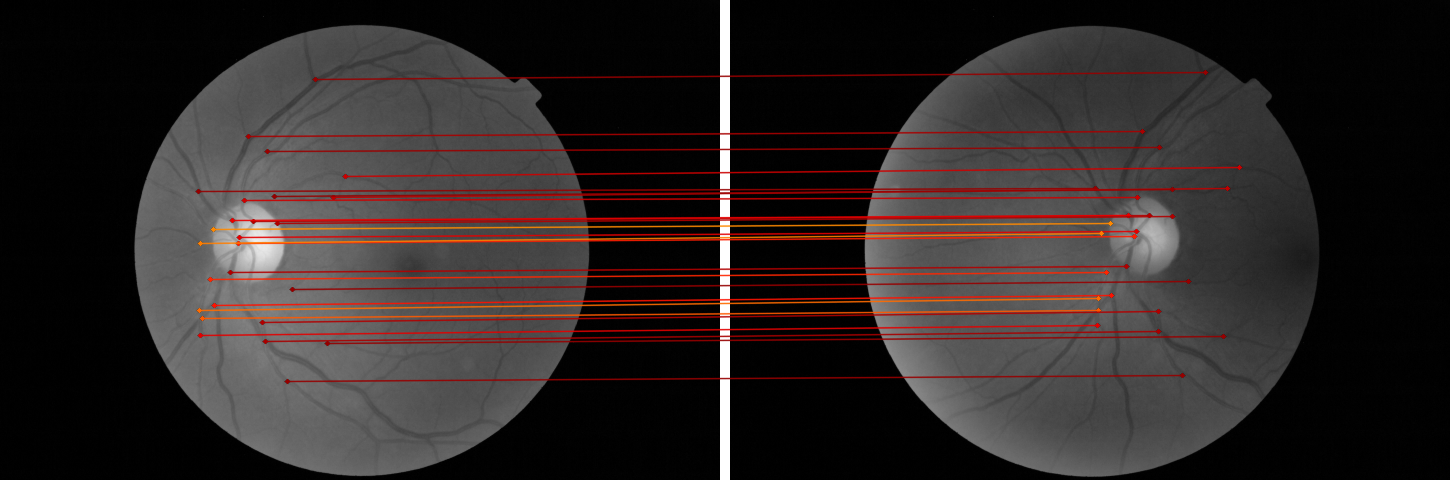

Epoch [3/5], Step [5/95], Loss: 0.0368
Epoch [3/5], Step [15/95], Loss: 0.0706
Epoch [3/5], Step [20/95], Loss: 0.0522
Epoch [3/5], Step [30/95], Loss: 0.0335
Epoch [3/5], Step [45/95], Loss: 0.0317
Epoch [3/5], Step [55/95], Loss: 0.0259
Epoch [3/5], Step [65/95], Loss: 0.0649
Epoch [3/5], Step [75/95], Loss: 0.0833
Epoch [3/5], Step [85/95], Loss: 0.1018
Epoch [3/5], Step [90/95], Loss: 0.0633
Epoch [3/5], Step [95/95], Loss: 0.0688
Epoch [3/5] done. Epoch Loss 0.023418388844619463. Checkpoint saved to model_epoch_3.pth


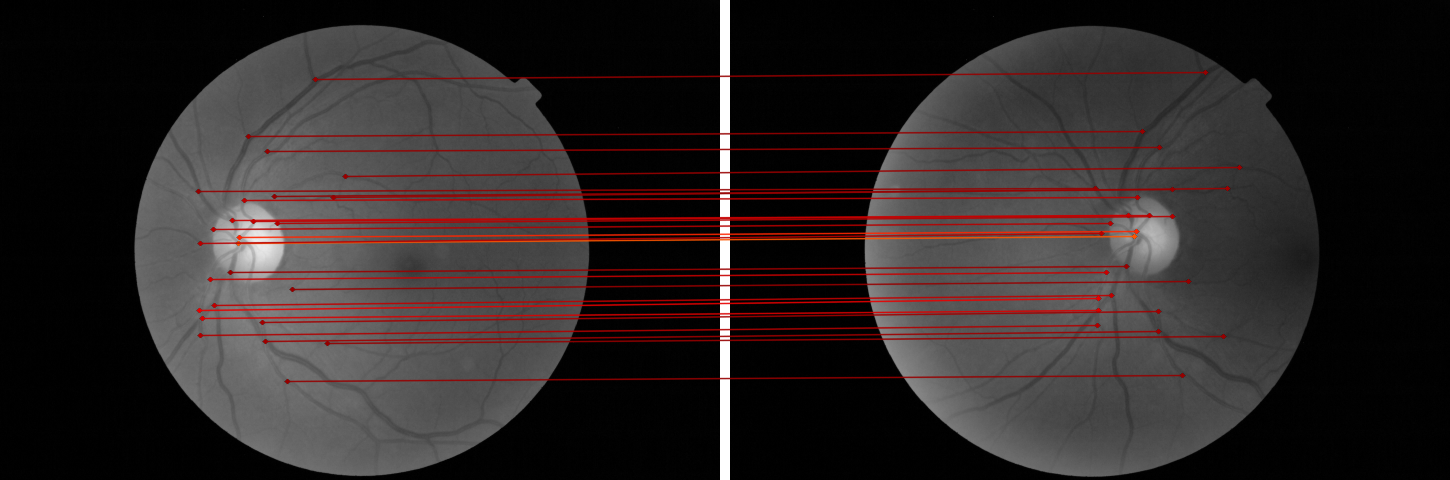

Epoch [4/5], Step [5/95], Loss: 0.0298
Epoch [4/5], Step [15/95], Loss: 0.0454
Epoch [4/5], Step [20/95], Loss: 0.0383
Epoch [4/5], Step [30/95], Loss: 0.0284
Epoch [4/5], Step [45/95], Loss: 0.0290
Epoch [4/5], Step [55/95], Loss: 0.0255
Epoch [4/5], Step [65/95], Loss: 0.0471
Epoch [4/5], Step [75/95], Loss: 0.0529
Epoch [4/5], Step [85/95], Loss: 0.0668
Epoch [4/5], Step [90/95], Loss: 0.0469
Epoch [4/5], Step [95/95], Loss: 0.0479
Epoch [4/5] done. Epoch Loss 0.016966462495366322. Checkpoint saved to model_epoch_4.pth


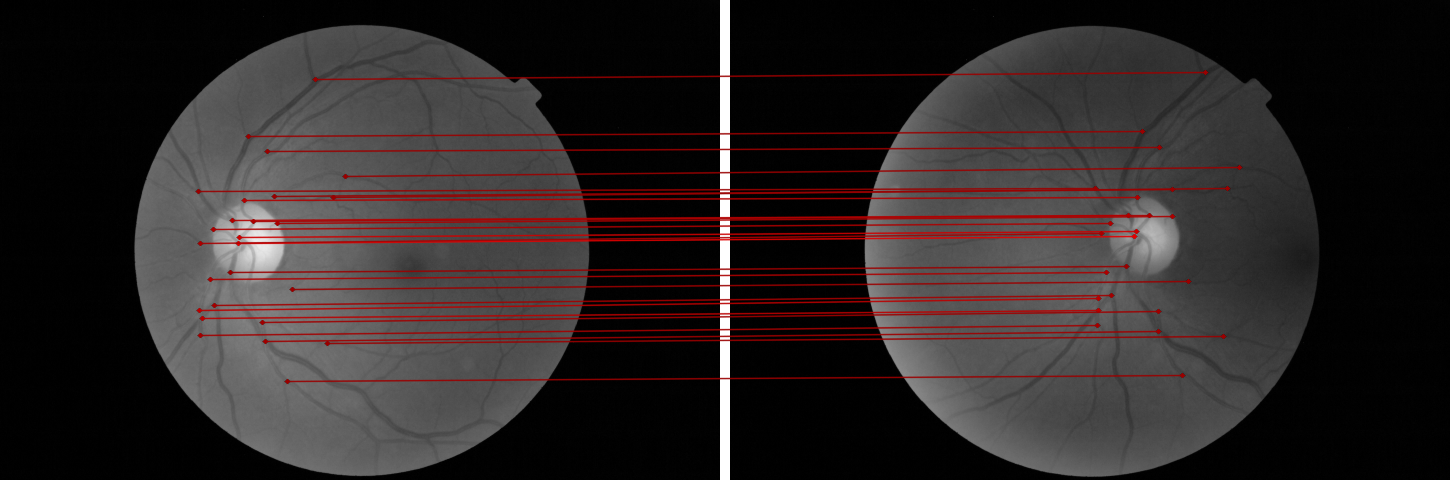

Epoch [5/5], Step [5/95], Loss: 0.0269
Epoch [5/5], Step [15/95], Loss: 0.0350
Epoch [5/5], Step [20/95], Loss: 0.0319
Epoch [5/5], Step [30/95], Loss: 0.0268
Epoch [5/5], Step [45/95], Loss: 0.0275
Epoch [5/5], Step [55/95], Loss: 0.0254
Epoch [5/5], Step [65/95], Loss: 0.0377
Epoch [5/5], Step [75/95], Loss: 0.0415
Epoch [5/5], Step [85/95], Loss: 0.0502
Epoch [5/5], Step [90/95], Loss: 0.0388
Epoch [5/5], Step [95/95], Loss: 0.0387
Epoch [5/5] done. Epoch Loss 0.01408698584295381. Checkpoint saved to model_epoch_5.pth


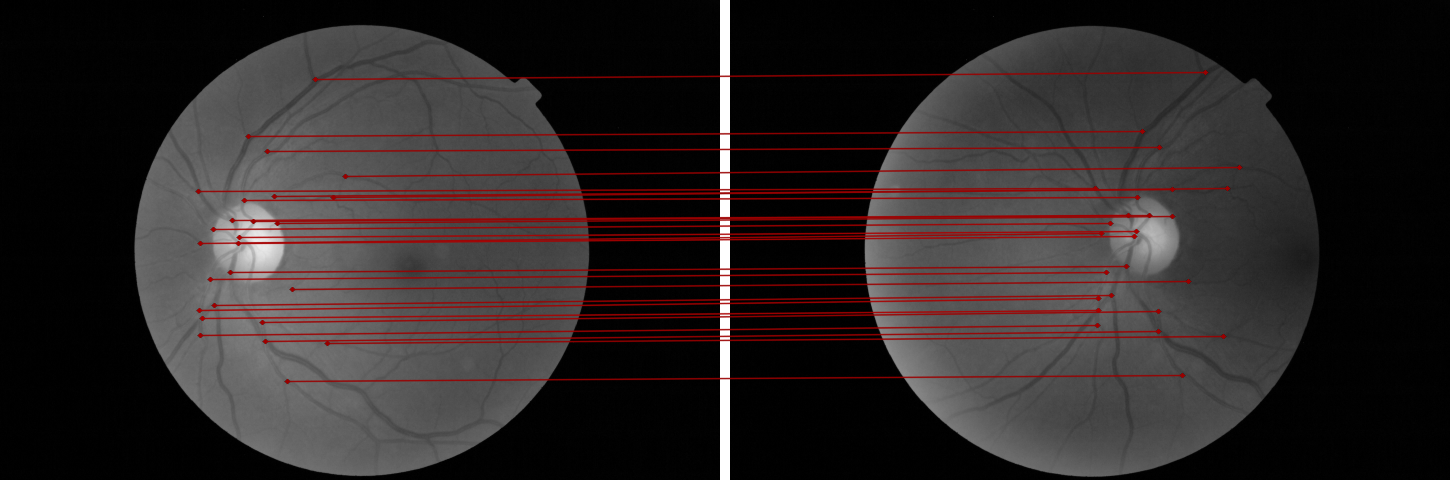

In [ ]:
from pathlib import Path
import argparse
import random
import numpy as np
import matplotlib.cm as cm
import torch
import torch.nn as nn
from torch.autograd import Variable
import os
import torch.multiprocessing
from tqdm import tqdm
from google.colab.patches import cv2_imshow

# Enable gradient calculations
torch.set_grad_enabled(True)
# Set sharing strategy to file system
torch.multiprocessing.set_sharing_strategy('file_system')

# Set output directory and create if not exists
eval_output_dir = Path('/content/drive/My Drive/SuperGlue-pytorch/dump_match_pairs/')
eval_output_dir.mkdir(exist_ok=True, parents=True)
# Define configuration parameters for the model
config = {
       'superglue': {
        'weights': 'indoor',
        'sinkhorn_iterations': 20,
        'match_threshold': 0.2,
    }
}

# load training data
train_set = SparseDataset('/content/drive/My Drive/GoodPairs', 100)
train_loader = torch.utils.data.DataLoader(dataset=train_set, shuffle=False, batch_size=1, drop_last=True)

# Initialize the SuperGlue model with given configuration
superglue = SuperGlue(config.get('superglue', {}))

# Check if CUDA is available and set the model to train on GPU if it is
if torch.cuda.is_available():
    superglue.cuda() # make sure it trains on GPU
else:
    print("### CUDA not available ###")

# Define the optimizer
optimizer = torch.optim.Adam(superglue.parameters(), lr=0.0001)
mean_loss = []

# Set the number of epochs
epochs = 5
# Start training
for epoch in range(1, epochs+1):
    epoch_loss = 0
    # Set the model to train mode for the current epoch
    superglue.double().train()
    for i, pred in enumerate(train_loader):
      # Send the data to the GPU if available
        for k in pred:
            if k != 'file_name' and k!='image0' and k!='image1':
                if type(pred[k]) == torch.Tensor:
                    pred[k] = Variable(pred[k].cuda())
                else:
                    pred[k] = Variable(torch.stack(pred[k]).cuda())
            
        data = superglue(pred)
        for k, v in pred.items():
            pred[k] = v[0]
        pred = {**pred, **data}

        if pred['skip_train'] == True: # image has no keypoint
            continue
        
        # process loss
        Loss = pred['loss']
        epoch_loss += Loss.item()
        mean_loss.append(Loss)

        superglue.zero_grad()
        Loss.backward()
        optimizer.step()

        # for every 50 images, print progress and visualize the matches
        if (i+1) % 5 == 0:
            print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}' 
                .format(epoch, epochs, i+1, len(train_loader), torch.mean(torch.stack(mean_loss)).item())) 
            mean_loss = []

            ### eval ###
            # Visualize the matches.
            superglue.eval()
            image0, image1 = pred['image0'].cpu().numpy()[0]*255., pred['image1'].cpu().numpy()[0]*255.
            kpts0, kpts1 = pred['keypoints0'].cpu().numpy()[0], pred['keypoints1'].cpu().numpy()[0]
            matches, conf = pred['matches0'].cpu().detach().numpy(), pred['matching_scores0'].cpu().detach().numpy()
            image0 = read_image_modified(image0,[720,480], 1)
            image1 = read_image_modified(image1,[720,480], 1)
            valid = matches > -1
            mkpts0 = kpts0[valid]
            mkpts1 = kpts1[matches[valid]]
            mconf = conf[valid]
            viz_path = eval_output_dir / '{}_matches.{}'.format(str(i), 'png')
            color = cm.jet(mconf)
            stem = pred['file_name']
            text = []

            make_matching_plot(image0, image1, kpts0, kpts1, mkpts0, mkpts1, color,text, viz_path, stem, stem, 1,1, 0, 'matches')
            

        # process checkpoint for every 50 images
        if (i+1) % 50 == 0:
            model_out_path = "model_epoch_{}.pth".format(epoch)
            torch.save(superglue, model_out_path)
            print ('Epoch [{}/{}], Step [{}/{}], Checkpoint saved to {}' 
                .format(epoch, epochs, i+1, len(train_loader), model_out_path)) 

    # save checkpoint when an epoch finishes
    epoch_loss /= len(train_loader)
    model_out_path = "model_epoch_{}.pth".format(epoch)
    torch.save(superglue, model_out_path)
    print("Epoch [{}/{}] done. Epoch Loss {}. Checkpoint saved to {}"
        .format(epoch, epochs, epoch_loss, model_out_path))
    match_img = cv2.imread('/content/drive/My Drive/SuperGlue-pytorch/dump_match_pairs/4_matches.png')
    cv2_imshow(match_img)

 